In [1]:
from mpvn.model import *
from mpvn.metric import *
import pytorch_lightning as pl
from mpvn.configs import DictConfig
from mpvn.data.grad.lit_data_module import LightningGradDataModule
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

configs = DictConfig()

data_module = LightningGradDataModule(configs)
vocab = data_module.get_vocab()

/home/wicii/miniconda3/envs/grad/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/wicii/miniconda3/envs/grad/lib/python3.8/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: latest is an invalid version and will not be supported in a future release
  warnings.warn(


In [2]:
checkpoint_callback = ModelCheckpoint(
    save_top_k=3,
    monitor="valid_loss",
    mode="min",
    dirpath="checkpoint",
    filename="mpvn-{epoch:02d}-{valid_loss:.2f}-{valid_per:.2f}",
)
early_stop_callback = EarlyStopping(
    monitor="valid_loss", 
    min_delta=0.00, 
    patience=5, 
    verbose=False, 
    mode="min"
)
logger = TensorBoardLogger("tensorboard", name="Pronunciation for Vietnamese")

trainer = pl.Trainer(accelerator='cpu',
                      logger=logger,
                      max_epochs=configs.max_epochs,
                      callbacks=[checkpoint_callback, early_stop_callback])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [3]:
model = ConformerRNNModel.load_from_checkpoint(
    'Checkpoint/lstm-epoch=05-valid_loss=0.37-valid_per=0.51.ckpt',
    configs=configs,
    num_classes=len(vocab),
    vocab=vocab,
    per_metric=WordErrorRate(vocab)
)

/home/wicii/miniconda3/envs/grad/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [4]:
trainer.test(model, data_module)

Testing DataLoader 0:   0%|          | 2/760 [00:00<02:14,  5.63it/s]

/home/wicii/miniconda3/envs/grad/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:98: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Testing DataLoader 0:  24%|██▍       | 185/760 [00:25<01:18,  7.30it/s]

/home/wicii/miniconda3/envs/grad/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:653: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


Validation DataLoader 0:   0%|          | 0/760 [00:00<?, ?it/s]
1 sample result
EP: torch.Size([83]) __________t_iɛɜww-t̪yəɜŋ---ff_ɔ2ŋ--v_iɜ--v_ɔ6_---tʃ_ɔ_-biɛɜt̪________________<e><e><e><e><e><e><e><e><e><e><e><e>
DP    : torch.Size([26]) tiɛɜw-t̪yəɜŋ-fɔ2m-vwiɜ-ŋɔ6-tʃɔ2-biɛɜt̪<e>
Target: torch.Size([26]) tiɛɜw-t̪yəɜŋ-faː6m-kwiɜ-ŋɔ6-tʃɔ-biɛɜt̪<e>
Per: 0.15
Attention: torch.Size([4, 26, 83])
torch.Size([26, 83])


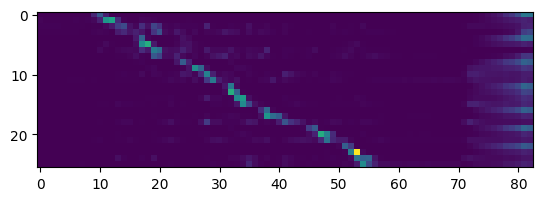

Validation DataLoader 0:   9%|▊         | 66/760 [00:09<01:41,  6.82it/s]

/home/wicii/miniconda3/envs/grad/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:653: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [11]:
trainer.validate(model, data_module)

In [26]:
with open('log.log', 'w') as f:
    for i, attn in enumerate(model.save_attn):
        print(i, attn.softmax(dim=-1), file=f)
        print(i, torch.sum(model.save_context.squeeze(), dim=-1)[i], file=f)

In [12]:
model.save_context.shape
SIL -> key -> score 

torch.Size([1, 39, 144])

In [25]:
torch.sum(model.save_context.squeeze(), dim=-1).shape

torch.Size([39])

In [3]:
wer = WordErrorRate(vocab)

In [6]:
wer([[4,11]], [[4,11]])

0.0